In [1]:
import re
import os
import cv2
import html
import string
import numpy as np
import numba as nb
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Mounting the drive to test the output file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#helper.py file

SMALL_HEIGHT = 800
def implt(img, cmp=None, t=''):
    """Show image using plt."""
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

def resize(img, height=SMALL_HEIGHT, always=False):
    """Resize image to given height."""
    if (img.shape[0] > height or always):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img

def ratio(img, height=SMALL_HEIGHT):
    """Getting scale ratio."""
    return img.shape[0] / height


def img_extend(img, shape):
    """Extend 2D image (numpy array) in vertical and horizontal direction.
    Shape of result image will match 'shape'
    Args:
        img: image to be extended
        shape: shape (touple) of result image
    Returns:
        Extended image
    """
    x = np.zeros(shape, np.uint8)
    x[:img.shape[0], :img.shape[1]] = img
    return x


## Please change the path to the path of the dataset when required to test the data.

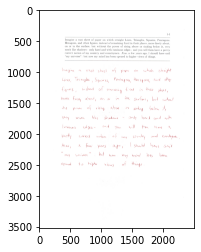

In [ ]:
img=cv2.imread('/content/drive/Shareddrives/IDS 560 - Capstone/Client Submission/Dataset/page1.jpg', cv2.COLOR_BGR2RGB)
implt(img)

## Getting cordinates of each line

In [ ]:
def detection_page(image, area_thresh = 0.5):
    """Finding Page."""
    small = resize(image)
    # Edge detection
    image_edges = _edges_detection(small, 200, 250)
    
    # Close gaps between edges (double page clouse => rectangle kernel)
    closed_edges = cv2.morphologyEx(image_edges, 
                                    cv2.MORPH_CLOSE, 
                                    np.ones((5, 11)))
    # Countours
    page_contour = _find_page_contours(closed_edges, small, area_thresh)

    # Recalculate to original scale
    page_contour = page_contour.dot(ratio(image, small.shape[0]))
    # Transform prespective
    new_image = _persp_transform(image, page_contour)
    return new_image
   

def _edges_detection(img, minVal, maxVal):
    """Preprocessing (gray, thresh, filter, border) + Canny edge detection."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 115, 4)

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5,
                             cv2.BORDER_CONSTANT,
                             value=[0, 0, 0])
    return cv2.Canny(img, minVal, maxVal)


def _four_corners_sort(pts):
    """Sort corners in order: top-left, bot-left, bot-right, top-right."""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def _contour_offset(cnt, offset):
    """Offset contour because of 5px border."""
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def _find_page_contours(edges, img, area_thresh):
    """Finding corner points of page contour."""
    contours, hierarchy = cv2.findContours(edges,
                                                cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * area_thresh
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                             [0, height-5],
                             [width-5, height-5],
                             [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = _four_corners_sort(page_contour)
    return _contour_offset(page_contour, (-5, -5))


def _persp_transform(img, s_points):
    """Transform perspective from start points to target points."""
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))

## Creating bounding boxes around the words

In [ ]:
def detection_words(image, join=False):
    """Detecting the words bounding boxes.
    Return: numpy array of bounding boxes [x, y, x+w, y+h]
    """
    # Preprocess image for word detection
    blurred = cv2.GaussianBlur(image, (5, 5), 18)
    edge_img = _edge_detect(blurred)
    ret, edge_img = cv2.threshold(edge_img, 50, 255, cv2.THRESH_BINARY)
    bw_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE,
                              np.ones((15,15), np.uint8))

    return _text_detect(bw_img, image, join)


def sort_words(boxes):
    """Sort boxes - (x, y, x+w, y+h) from left to right, top to bottom."""
    mean_height = sum([y2 - y1 for _, y1, _, y2 in boxes]) / len(boxes)
    
    boxes.view('i8,i8,i8,i8').sort(order=['f1'], axis=0)
    current_line = boxes[0][1]
    lines = []
    tmp_line = []
    for box in boxes:
        if box[1] > current_line + mean_height:
            lines.append(tmp_line)
            tmp_line = [box]
            current_line = box[1]            
            continue
        tmp_line.append(box)
    lines.append(tmp_line)
        
    for line in lines:
        line.sort(key=lambda box: box[0])
        
    return lines


def _edge_detect(im):
    """ 
    Edge detection using sobel operator on each layer individually.
    Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([_sobel_detect(im[:,:, 0]),
                            _sobel_detect(im[:,:, 1]),
                            _sobel_detect(im[:,:, 2])]), axis=0)


def _sobel_detect(channel):
    """Sobel operator."""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def _intersect(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0:
        return False
    return True

def _group_rectangles(rec):
    """
    Uion intersecting rectangles.
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and _intersect(rec[i], rec[j]):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1
            
    return final


def _text_detect(img, image, join=False):
    """Text detection using contours."""
    small = resize(img, 2000)
    
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    cnt, hierarchy = cv2.findContours(np.copy(small),
                                           cv2.RETR_CCOMP,
                                           cv2.CHAIN_APPROX_SIMPLE)
    
    index = 0    
    boxes = []
    # Go through all contours in top level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if (r > 0.1
            and 1600 > w > 10
            and 1600 > h > 10
            and h/w < 3
            and w/h < 10
            and (60 // h) * w < 1000):
            boxes += [[x, y, w, h]]
            
        index = hierarchy[0][index][0]

    if join:
        # Need more work
        boxes = _group_rectangles(boxes)

    # image for drawing bounding boxes
    small = cv2.cvtColor(small, cv2.COLOR_GRAY2RGB)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(small, (x, y),(x+w,y+h), (0, 255, 0), 2)
        bounding_boxes = np.vstack((bounding_boxes,
                                    np.array([x, y, x+w, y+h])))
        
    implt(small, t='Bounding rectangles')
    
    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)
    return boxes[1:]  
    

def textDetectWatershed(thresh):
    """    """
    img = cv2.cvtColor(cv2.imread("data/textdet/%s.jpg" % IMG),
                       cv2.COLOR_BGR2RGB)
    img = resize(img, 3000)
    thresh = resize(thresh, 3000)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,
                                 0.01*dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers += 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    markers = cv2.watershed(img, markers)
    implt(markers, t='Markers')
    image = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    for mark in np.unique(markers):
        # mark == 0 --> background
        if mark == 0:
            continue

        # Draw it on mask and detect biggest contour
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[markers == mark] = 255

        cnts = cv2.findContours(mask.copy(),
                                cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(cnts, key=cv2.contourArea)
        
        # Draw a bounding rectangle if it contains text
        x,y,w,h = cv2.boundingRect(c)
        cv2.drawContours(mask, c, 0, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if r > 0.2 and 2000 > w > 15 and 1500 > h > 15:
            cv2.rectangle(image, (x, y),(x+w,y+h), (0, 255, 0), 2)
        
    implt(image)


## Cropping the image and identfying the bounding boxes

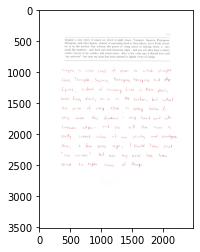

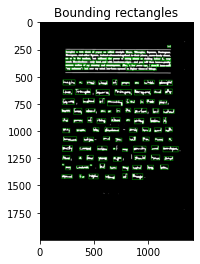

In [ ]:
crop = detection_page(img)
implt(crop)
boxes = detection_words(crop)
lines = sort_words(boxes)

## Installing transfomers model

In [ ]:
!pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from IPython.display import display

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten") 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## Importing Mircosoft TROCR model

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Functions for opening and processing the image

In [ ]:
def show_image(pathStr):
    img = Image.open(pathStr).convert("RGB")
    display(img)
    return img

In [ ]:
def given_image(src_img):
    pixel_values = processor(images=src_img, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

## Please change the path to the path of the dataset when required to test the data.

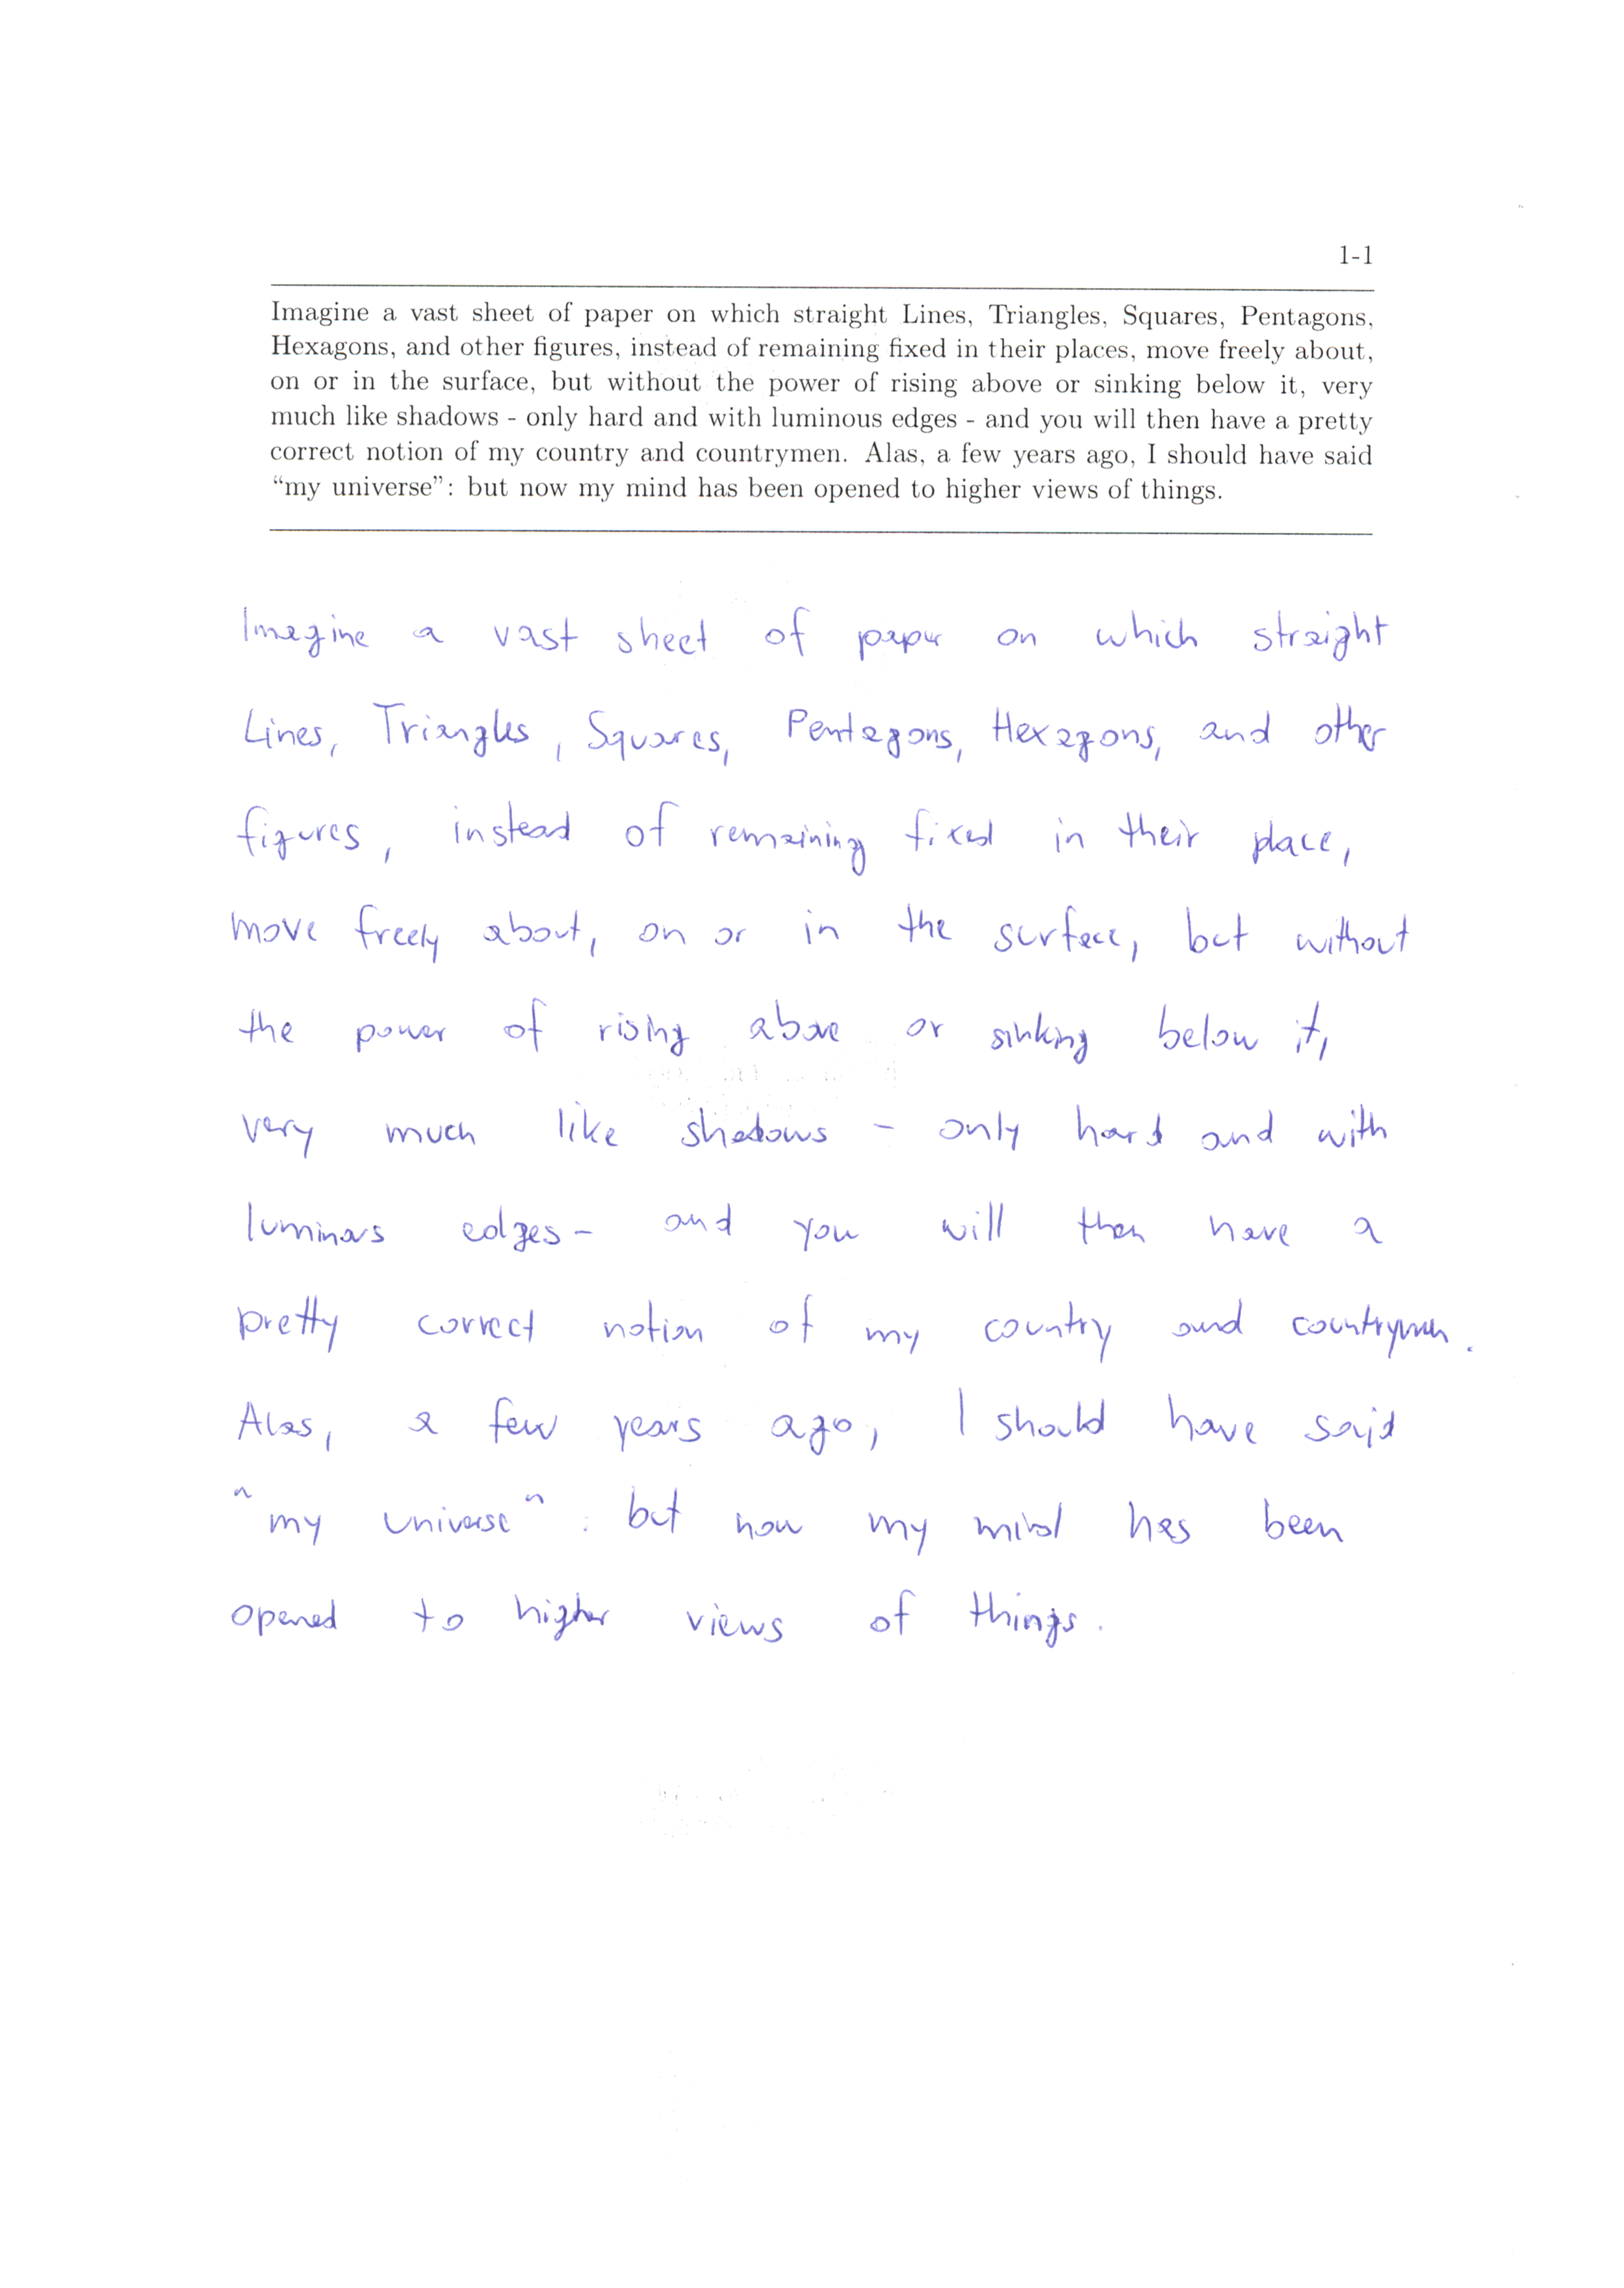

In [ ]:
hw_image = show_image('/content/drive/Shareddrives/IDS 560 - Capstone/Client Submission/Dataset/page1.jpg')

## Creating a final list which stores all the output

In [ ]:
answer_list = []

min value of x1 is:  2056
max value of y1 is:  374
max value of y2 is:  409


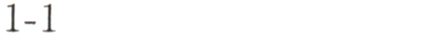

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  413
max value of y1 is:  472
max value of y2 is:  509


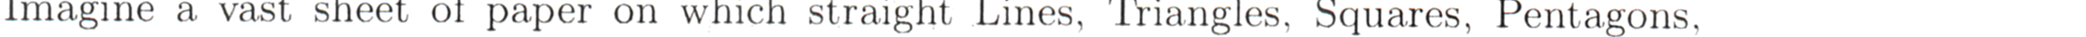

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  409
max value of y1 is:  623
max value of y2 is:  718


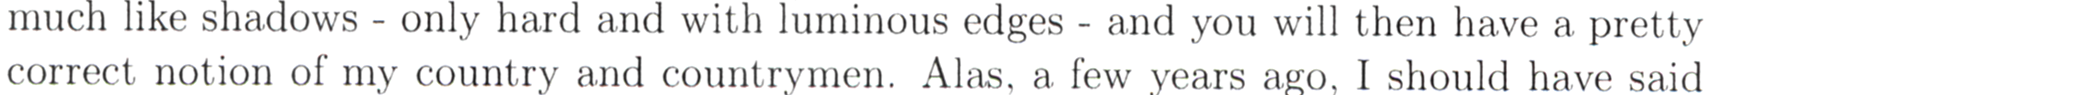

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  409
max value of y1 is:  729
max value of y2 is:  780


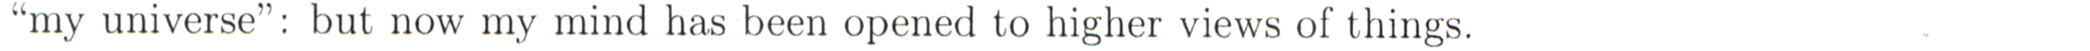

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  369
max value of y1 is:  966
max value of y2 is:  1021


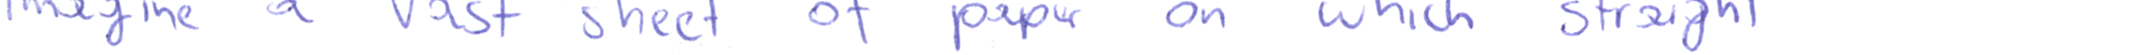

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  370
max value of y1 is:  1091
max value of y2 is:  1182


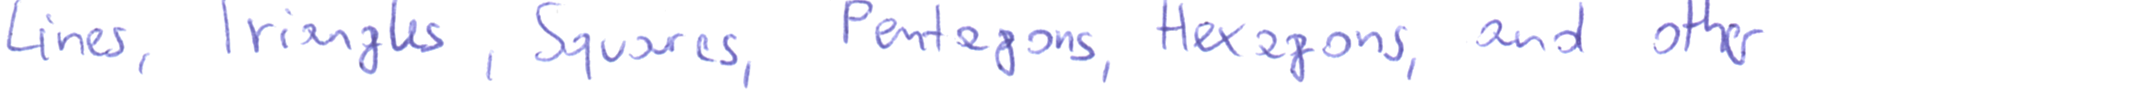

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  358
max value of y1 is:  1261
max value of y2 is:  1351


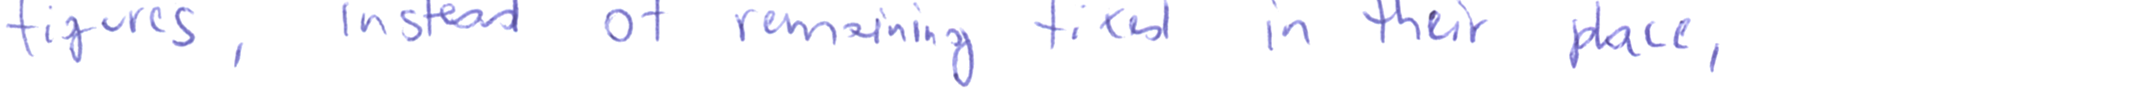

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  349
max value of y1 is:  1425
max value of y2 is:  1486


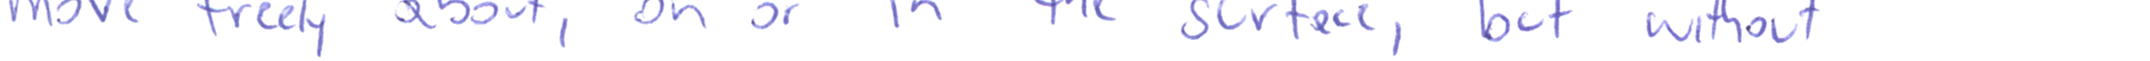

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  362
max value of y1 is:  1574
max value of y2 is:  1641


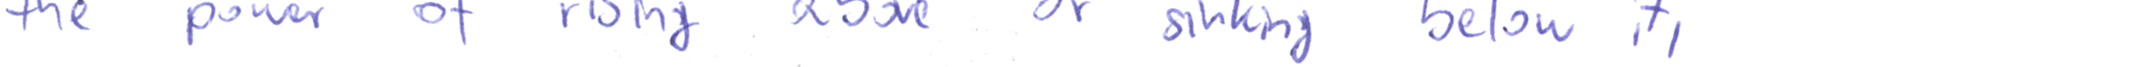

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  367
max value of y1 is:  1725
max value of y2 is:  1785


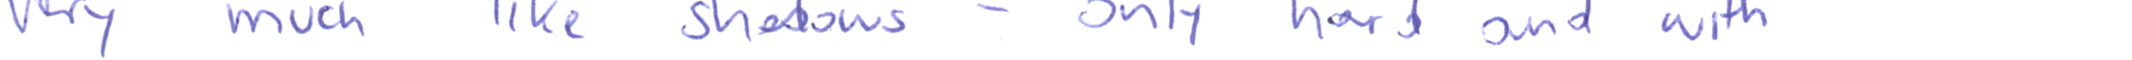

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  376
max value of y1 is:  1871
max value of y2 is:  1931


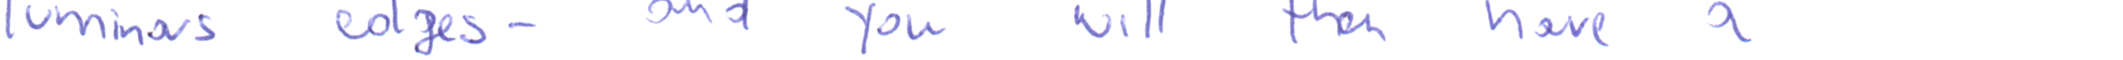

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  360
max value of y1 is:  2040
max value of y2 is:  2100


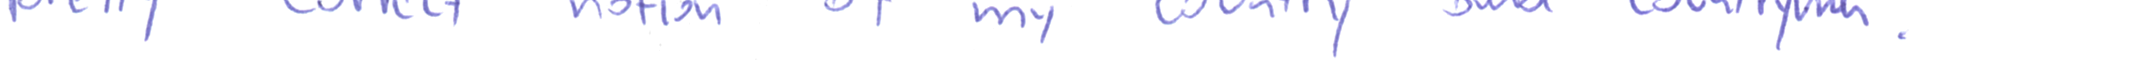

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  362
max value of y1 is:  2175
max value of y2 is:  2244


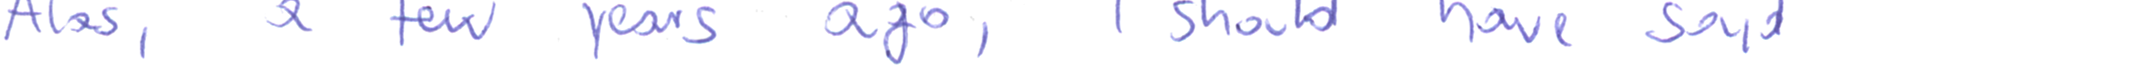

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  356
max value of y1 is:  2328
max value of y2 is:  2397


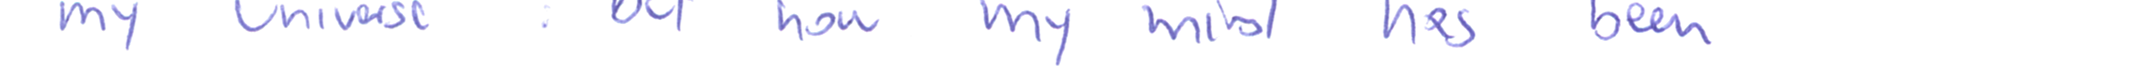

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


min value of x1 is:  351
max value of y1 is:  2483
max value of y2 is:  2539


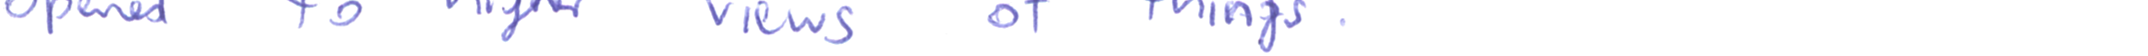

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
for line in lines:
    x1 = []
    y1 = []
    y2 = []
    for words in line:
        x1.append(words[0])
        y1.append(words[1])
        y2.append(words[3])
    
    min_x1 = min(x1)
    max_y1 = max(y1)
    max_y2 = max(y2)
    print('min value of x1 is: ',min_x1)
    print('max value of y1 is: ', max_y1)
    print('max value of y2 is: ', max_y2)
    hw_image2 = hw_image.crop((min_x1,max_y1, hw_image.size[0], max_y2))
    display(hw_image2)
    given_image(hw_image2)
    answer_list.append(given_image(hw_image2))
    #print('next line')

## Final Output

In [ ]:
print(answer_list)

['I-I-000', 'Imagine a vast sheet of paper on which straight lines, Triangle, Squares, Pentagons,', 'until the shadows - only hard and with numerous sides and you will then have a pretty', '" my universe " : but now my mind has been opened to higher views of things.', 'Imagine a vast sheet of paper on which straight', 'Lines, Iringles, Squares, Pentagon, Hexagons, and other', 'figures, Instead of remaining tired in their place,', 'have freely about, on or in the surface, but without', 'the power of roing, was a strong below it,', 'Very much like Shadows. Only hard and with', 'luminous edges - and you will then have a', 'many could happen of my country and everyone.', 'Alan, a few years ago, I should have said', 'my universe : but how my mind has been', 'opened to inform views of things.']
